In [3]:
%%time

import os


from adlfs import AzureBlobFileSystem
from common.functions.functions import Functions

import pandas
from tqdm import tqdm

from common.storage.azure_file_storage import AzureFileStorageAdapter

tqdm.pandas(desc="Progress")
file_system: AzureBlobFileSystem = AzureFileStorageAdapter('data').get_file_storage()

functions: Functions = Functions()

CPU times: total: 10.7 s
Wall time: 26.9 s


In [6]:
df: pandas.DataFrame = pandas.read_parquet('data/parquet/thumbnail_curation.parquet', engine='pyarrow', filesystem=file_system)

sexy = df.where(
	(df['model'] == 'SexyDiffusion') |
	(df['model'] == 'SWFPetite') |
	(df['model'] == 'RedHeadDiffusion') |
	(df['model'] == 'NextDoorGirlsDiffusion') |
	(df['model'] == 'SexyAsianDiffusion') |
	(df['model'] == 'PrettyGirlDiffusion'))

sexy = sexy.where(df['thumbnail_accept'] == True)

sexy.dropna(inplace=True)
sexy.reset_index(inplace=True, drop=True)

display(sexy)



,id,subreddit,author,title,caption,hash,permalink,original_url,image_name,path,...,exists,curated,accept,tags,azure_caption,thumbnail_path,thumbnail_exists,thumbnail_curated,thumbnail_accept,additional_captions
0,1013bdt,AmIhotAF,RaulDea9286,36F - ITALIAN,arafed image of a woman in a bikini top,7c0d158cba8654ef1c635cbc5471d597,/r/AmIhotAF/comments/1013bdt/36f_italian/,https://i.redd.it/bg0wwdlt5k9a1.jpg,1013bdt.jpg,data/image/1013bdt.jpg,...,True,True,True,"[person, human face, clothing, lady, smile, ch...",a woman taking a selfie,data/image/thumbnail/1013bdt.jpg,True,True,True,"[a woman taking a selfie, a close up of an eye..."
1,105mekt,AmIhotAF,lindaniz,interesting in good forward relationship (f24),a close up of a woman with red hair and a whit...,ba4a0962cca2266a741e1e1700589c04,/r/AmIhotAF/comments/105mekt/interesting_in_go...,https://i.redd.it/4avjshsz8naa1.jpg,105mekt.jpg,data/image/105mekt.jpg,...,True,True,True,"[person, human face, skin, eyelash, eyebrow, b...",a woman taking a selfie,data/image/thumbnail/105mekt.jpg,True,True,True,"[a close up of a person's eye, a woman taking ..."
2,105qvgl,AmIhotAF,CaitVLove11,Laughing is my favorite 😆,a woman in a blue tank top and shorts is smili...,27bfe82c37314a0bcf02ab72eaf3a9e5,/r/AmIhotAF/comments/105qvgl/laughing_is_my_fa...,https://i.redd.it/2pulzr0lxmaa1.jpg,105qvgl.jpg,data/image/105qvgl.jpg,...,True,True,True,"[clothing, person, human face, smile, shoulder...",a woman smiling at camera,data/image/thumbnail/105qvgl.jpg,True,True,True,"[a woman smiling at camera, a woman with long ..."
3,105rpcj,AmIhotAF,Flashy-Desk1858,[f22] What do you think when you see me?,a woman in a blue bikini top and a blue bra top,329eb42b8267fa1cc2980da8e48bcef1,/r/AmIhotAF/comments/105rpcj/f22_what_do_you_t...,https://i.redd.it/rz68pf934naa1.jpg,105rpcj.jpg,data/image/105rpcj.jpg,...,True,True,True,"[person, human face, indoor, woman, chest, sho...",a woman taking a selfie,data/image/thumbnail/105rpcj.jpg,True,True,True,"[a woman taking a selfie, close up of a person..."
4,105styc,AmIhotAF,Gizzygirl127,Low key… still bangable?,smiling woman sitting on couch with remote con...,6d555943be4fbc21ff92417c6f582298,/r/AmIhotAF/comments/105styc/low_key_still_ban...,https://i.redd.it/aiaxxoz9uoaa1.jpg,105styc.jpg,data/image/105styc.jpg,...,True,True,True,"[person, human face, smile, clothing, woman, i...",a woman taking a selfie,data/image/thumbnail/105styc.jpg,True,True,True,"[a woman smiling at the camera, close-up of a ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1694,5cezff,gentlemanboners,SymptomaticFiend,Amanda Seyfried,arafed woman in a blue dress posing for a picture,be4f2d2f56498a641af2224fe118827e,/r/gentlemanboners/comments/5cezff/amanda_seyf...,http://i.imgur.com/IPkENSe.jpg,5cezff.jpg,data/image/5cezff.jpg,...,True,True,True,[],a woman in a blue dress,data/image/thumbnail/5cezff.jpg,True,True,True,"[a woman wearing a blue dress, a woman with bl..."
1695,5izxzc,gentlemanboners,Unknown,Scarlett Johansson in 2004,blond woman in a floral dress posing for a pic...,d4e7a3c6bc4ff0101da356a5a52d9bae,/r/gentlemanboners/comments/5izxzc/scarlett_jo...,http://i.imgur.com/Pds9CUj.jpg,5izxzc.jpg,data/image/5izxzc.jpg,...,True,True,True,[],a woman posing for a picture,data/image/thumbnail/5izxzc.jpg,True,True,True,"[a woman posing for a picture, a woman posing ..."
1696,5oawmv,gentlemanboners,TheSixteenSaltines,Alison Brie,araffe woman in a purple dress standing in fro...,037f4f4c153d73c579baec1427bfcc70,/r/gentlemanboners/comments/5oawmv/alison_brie/,http://i.imgur.com/saWmnUQ.jpg,5oawmv.jpg,data/image/5oawmv.jpg,...,True,True,True,[],a woman in a dress,data/image/thumbnail/5oawmv.jpg,True,True,True,"[a woman in a dress, a woman in a dress, a wom..."
1697,5q4ps8,gentlemanboners,Wooaahh,Hayley Williams,arafed woman in a black dress and blue heels s...,24d888ea939c42335e60c2776a0db4ad,/r/gentlemanboners/comments/5q4ps8/hayley_will...,http://i.imgur.com/aeG

<Axes: title={'center': 'Models with most images'}, xlabel='model'>

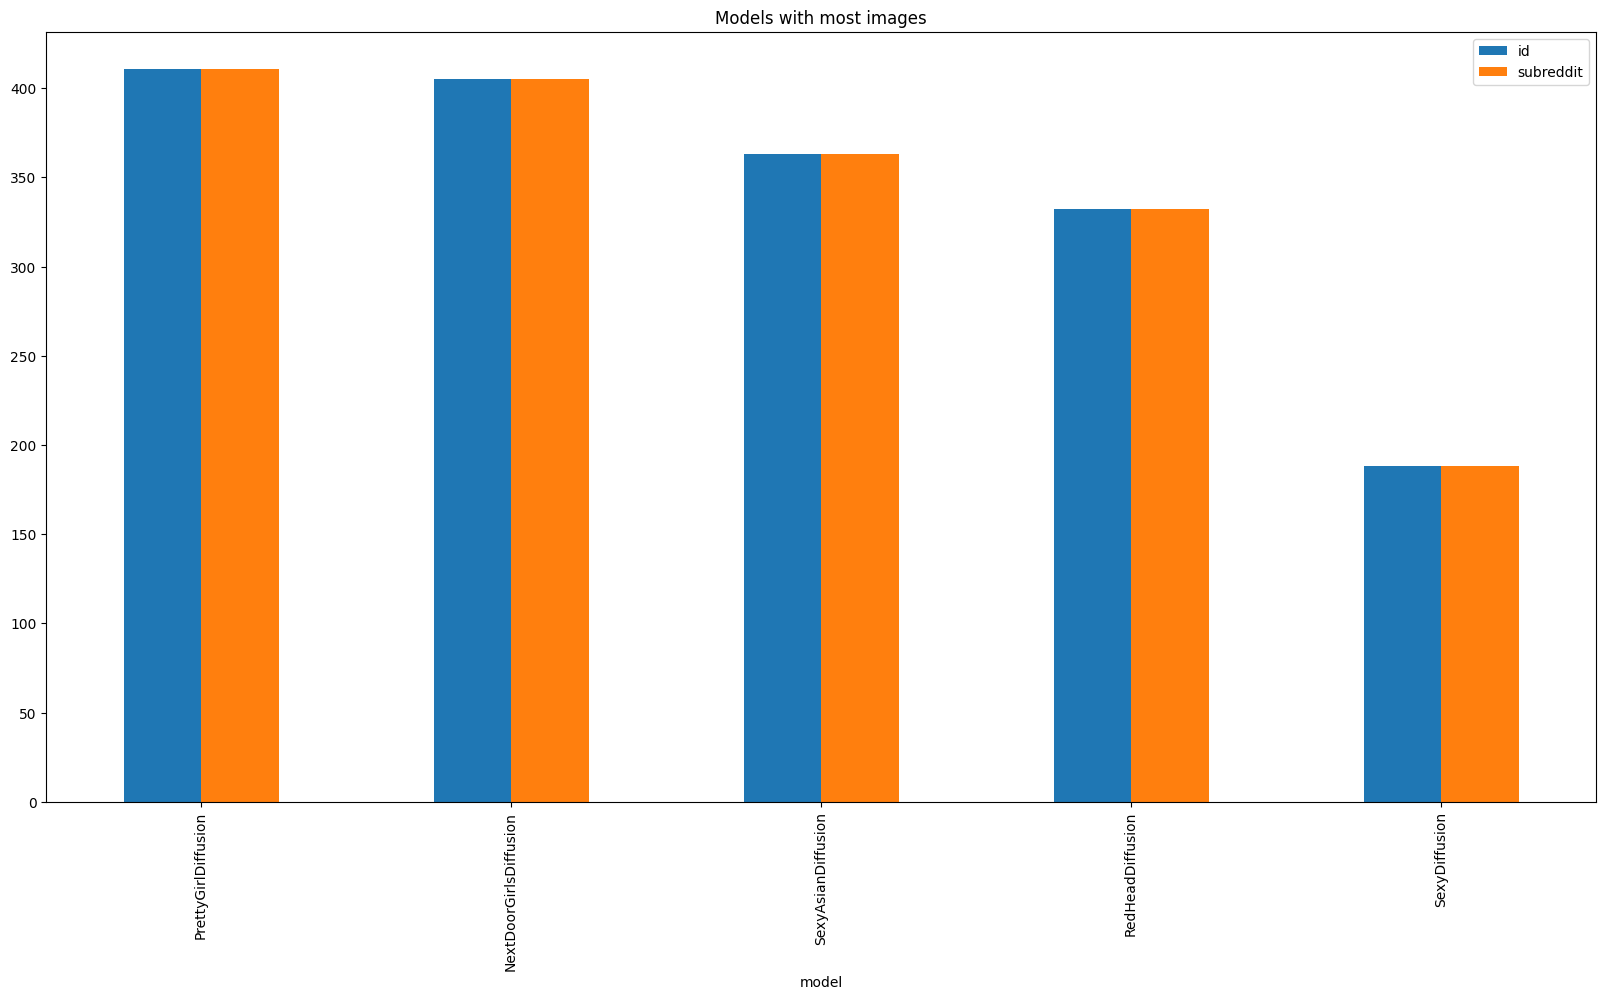

In [7]:
group = sexy[["id", "model", "subreddit"]].groupby(["model"]).count().sort_values(by="id", ascending=False)

plot_1 = group.plot.bar(figsize=(20, 10), title="Models with most images", legend=True)

display(plot_1)

In [8]:
os.makedirs('data', exist_ok=True)

In [9]:
lines = []
for elem in tqdm(sexy.to_dict(orient='records'), total=len(sexy)):
	image_name = elem['image_name']
	captions = elem['additional_captions'].tolist()
	captions.append(elem['azure_caption'])
	captions.append(elem['caption'])
	captions.append(elem['title'])
	captions = list(captions)
	data_row = {'file_name': image_name, 'text': captions}
	lines.append(data_row)
	file_system.cp(f'data/image/thumbnail/{image_name}', 'data/training/sexy')

df = pandas.DataFrame(data=lines)

display(df)

,file_name,text
0,1013bdt.jpg,"[a woman taking a selfie, a close up of an eye..."
1,105mekt.jpg,"[a close up of a person's eye, a woman taking ..."
2,105qvgl.jpg,"[a woman smiling at camera, a woman with long ..."
3,105rpcj.jpg,"[a woman taking a selfie, close up of a person..."
4,105styc.jpg,"[a woman smiling at the camera, close-up of a ..."
...,...,...
1694,5cezff.jpg,"[a woman wearing a blue dress, a woman with bl..."
1695,5izxzc.jpg,"[a woman posing for a picture, a woman posing ..."
1696,5oawmv.jpg,"[a woman in a dress, a woman in a dress, a wom..."
1697,5q4ps8.jpg,"[a woman in a black dress, a pair of blue feat..."


In [11]:
df.to_json('metadata.jsonl', orient='records', lines=True)

file_system.upload('metadata.jsonl', 'data/training/sexy', overwrite=True)

[None]

In [12]:
gpt_lines = []
for record in sexy.to_dict(orient='records'):
	name = record['model']
	prompt = record['title']
	captions = record['additional_captions'].tolist()
	captions.append(record['azure_caption'])
	captions.append(record['caption'])
	captions.append(record['title'])
	captions = list(set(captions))
	for caption in captions:
		line = f"<|startoftext|><|model|>{name}<|prompt|>{prompt}<|text|>{caption}<|endoftext|>" + "\n"
		gpt_lines.append(line)

with open("training.txt", "wb") as f:
	for line in gpt_lines:
		f.write(line.encode("utf-8"))

In [13]:
with open('training.txt', 'rb') as f:
	text = f.read()
	display(text)

b'<|startoftext|><|model|>SexyDiffusion<|prompt|>36F - ITALIAN<|text|>arafed image of a woman in a bikini top<|endoftext|>\n<|startoftext|><|model|>SexyDiffusion<|prompt|>36F - ITALIAN<|text|>a close up of an eye<|endoftext|>\n<|startoftext|><|model|>SexyDiffusion<|prompt|>36F - ITALIAN<|text|>36F - ITALIAN<|endoftext|>\n<|startoftext|><|model|>SexyDiffusion<|prompt|>36F - ITALIAN<|text|>a close up of a nose<|endoftext|>\n<|startoftext|><|model|>SexyDiffusion<|prompt|>36F - ITALIAN<|text|>a woman taking a selfie<|endoftext|>\n<|startoftext|><|model|>SexyDiffusion<|prompt|>interesting in good forward relationship (f24)<|text|>close up of a person\'s eyes<|endoftext|>\n<|startoftext|><|model|>SexyDiffusion<|prompt|>interesting in good forward relationship (f24)<|text|>a close up of a person\'s eye<|endoftext|>\n<|startoftext|><|model|>SexyDiffusion<|prompt|>interesting in good forward relationship (f24)<|text|>close up of a person\'s lips<|endoftext|>\n<|startoftext|><|model|>SexyDiffusi

In [14]:
file_system.upload('training.txt', 'data/training/training.txt', overwrite=True)

[None]

In [15]:
file_system.ls('data/training/training.txt')

['data/training/training.txt']